# MPDAF analysis for VANDELS data

This is an example notebook to illustrate the use of built in functions in MPDAF to ease the analysis of VANDELS spectra. More documentation about MPDAF and the functions can be found here: https://mpdaf.readthedocs.io/en/latest/index.html

This example extensively uses the Spectrum object from MPDAF. More details can be found here: https://mpdaf.readthedocs.io/en/latest/spectrum.html

In [ ]:
### Import essential packages

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u

import pyfits

from mpdaf.obj import Cube
from mpdaf.obj import Spectrum, WaveCoord

In [2]:
### Load your favourite spectrum

nomefile = "/Users/aayushsaxena/Desktop/VANDELS/test_spectra/sc_CDFS140458_P2M1Q1_P2M2Q1_P2M3Q1_P2M4Q1_009_1.fits"

In [3]:
### Read relevant info from VANDELS specific header entries
### Thanks Francesca!

hdulist = pyfits.open(nomefile)
flux= hdulist[0].data
header=hdulist[0].header
crval=header['CRVAL1']
cdelt=header['CDELT1']
z=header['HIERARCH PND Z']
flag=header['HIERARCH PND ZFLAGS']
objid=header['HIERARCH PND OBJID']
pix=np.arange(1,len(flux)+1)
lam_i=np.zeros(len(pix))
lam_i[0]=crval

for j in range(len(lam_i)-1):
    lam_i[j+1]=lam_i[j]+cdelt
    lam_i=lam_i#/(1+float(z)) #lamda rest frame
        
flux=flux#*(1+float(z)) #flux rest frame
noise=hdulist[3].data
noise=noise#*(1+float(z)) #noise rest frame


In [4]:
### Create spectrum object from VANDELS header info and spectrum

wavelength = WaveCoord(crval=crval, cdelt=cdelt, cunit=u.angstrom)
spectrum0 = Spectrum(wave=wavelength, data=flux, var=noise, unit=u.erg / u.second / u.cm**2 / u.angstrom)

spectrum0.info()

[INFO] 2154 Spectrum (no name)
[INFO] .data(2154) (erg / (Angstrom cm2 s)), .var(2154)
[INFO] wavelength: min:4801.25 max:10297.86 step:2.55 Angstrom


<IPython.core.display.Javascript object>


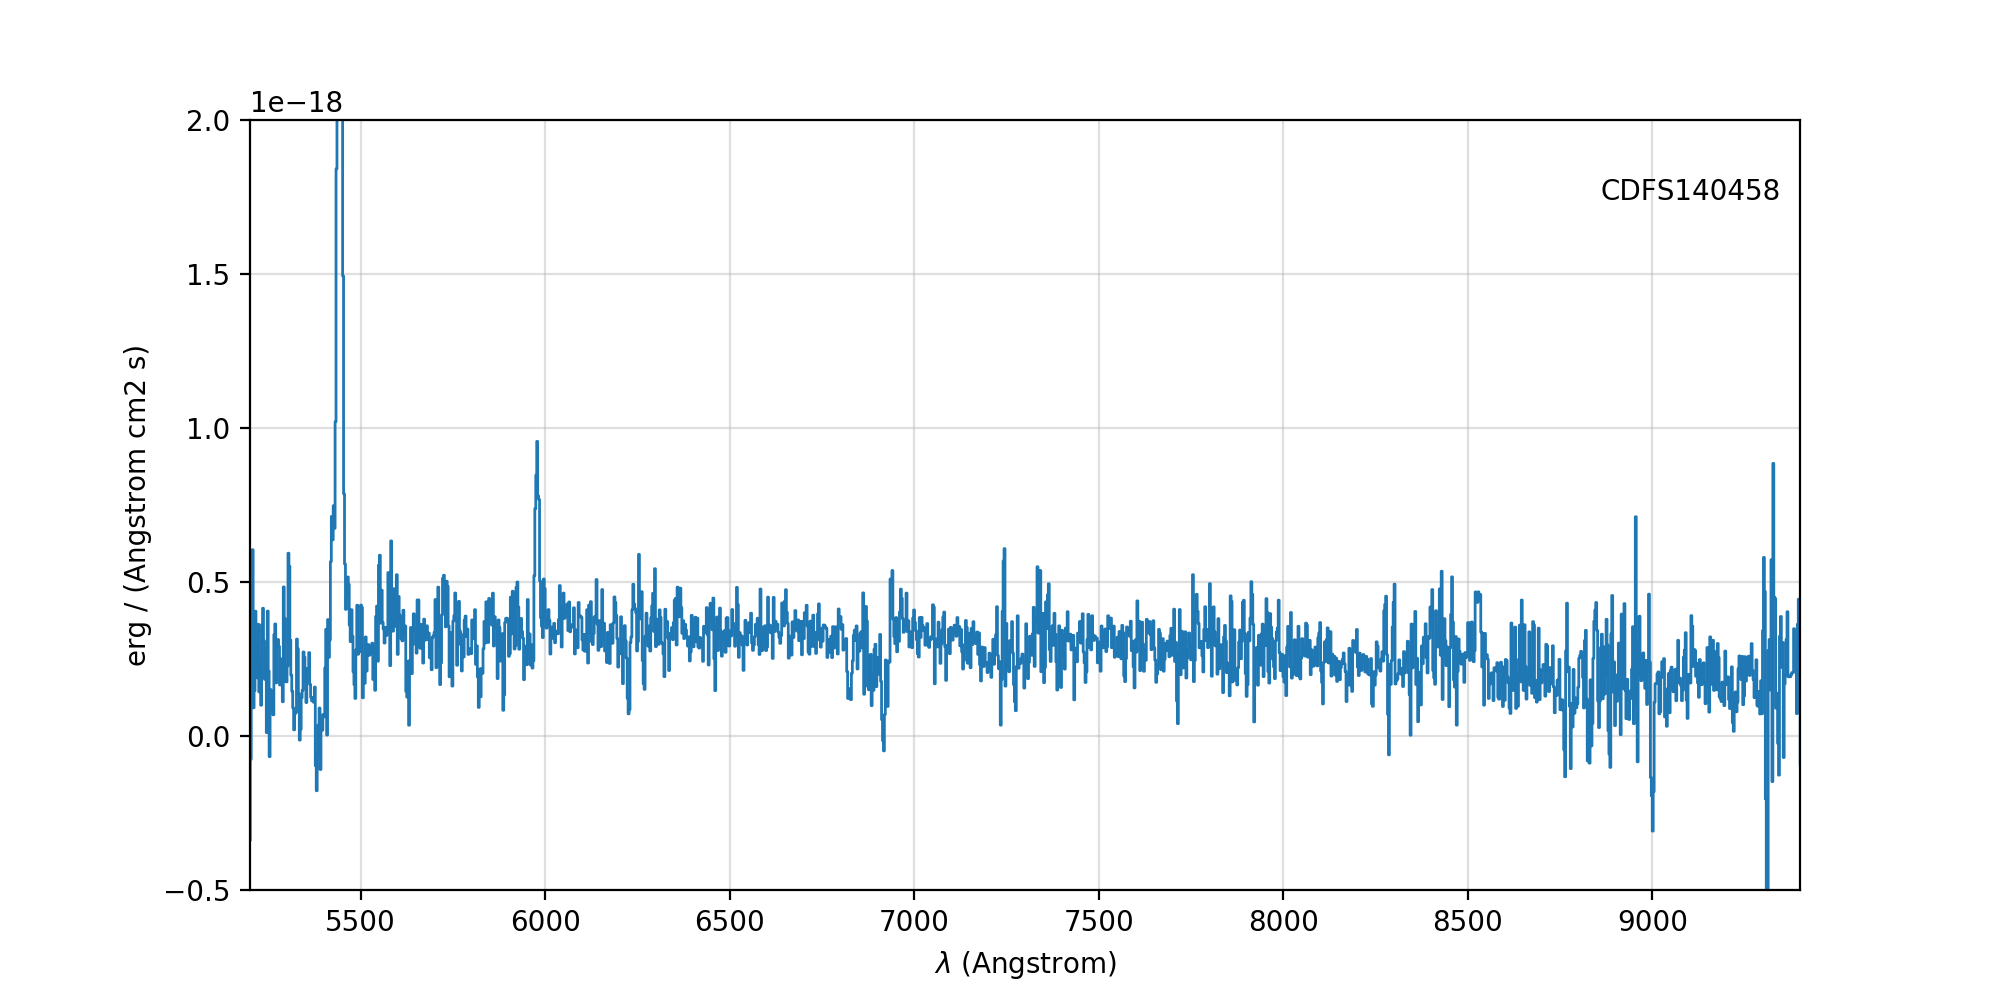

In [7]:
### Plot MPDAF VANDELS spectrum

%matplotlib notebook    # This command initialises an interactive plotting window. 
                        # This needs to be put before every new plot in each cell.

fig = plt.figure(figsize=(10,5))

## simple command from mpdaf to plot a spectrum
spectrum0.plot()

plt.figtext(0.8, 0.8, objid)
# plt.figtext(0.8, 0.76, "z = %s" %redshift) # print redshift of the object read from the FITS header if needed

### Plot limits
plt.xlim(5200, 9400)
plt.ylim(-0.5e-18, 0.2e-17)

plt.grid(alpha=0.4)
plt.show()

## Create a subspectrum in the wavelength region of your choice
For better fitting of known emission lines it may be useful to work with a subspectrum centred on the emission line. In this example I have created a subspectrum around the C II emission line at ~6000 A. For now I have not resampled the spectrum.

<IPython.core.display.Javascript object>


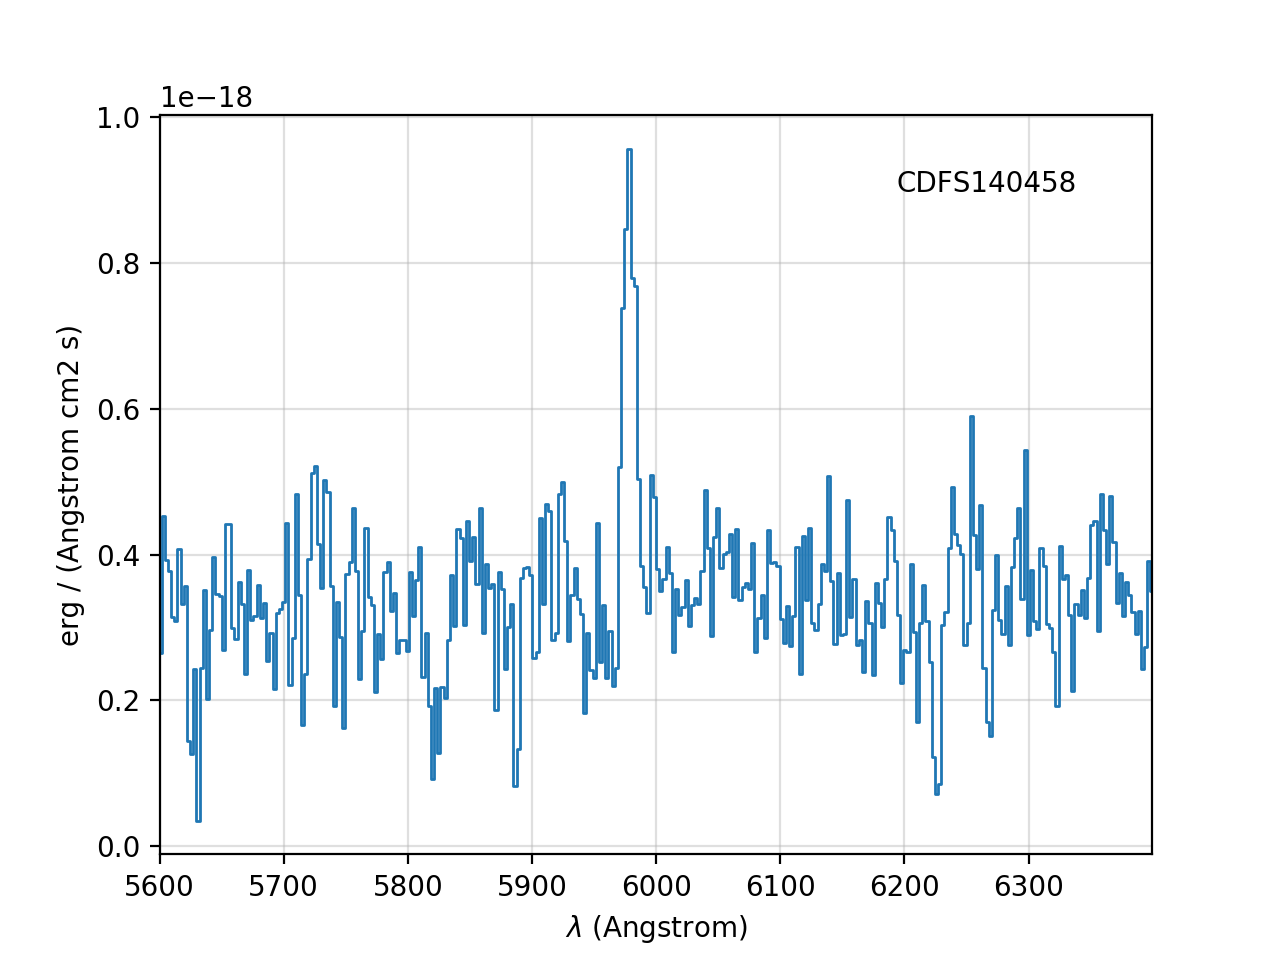

In [8]:
## Extract the relevant wavelength range and then Scale the WHT spectrum

subspec0 = spectrum0.subspec(lmin=5600, lmax=6400, unit=u.Angstrom)

%matplotlib notebook

subspec0.plot()
plt.figtext(0.7, 0.8, objid)

plt.grid(alpha=0.4)
plt.show()

<IPython.core.display.Javascript object>


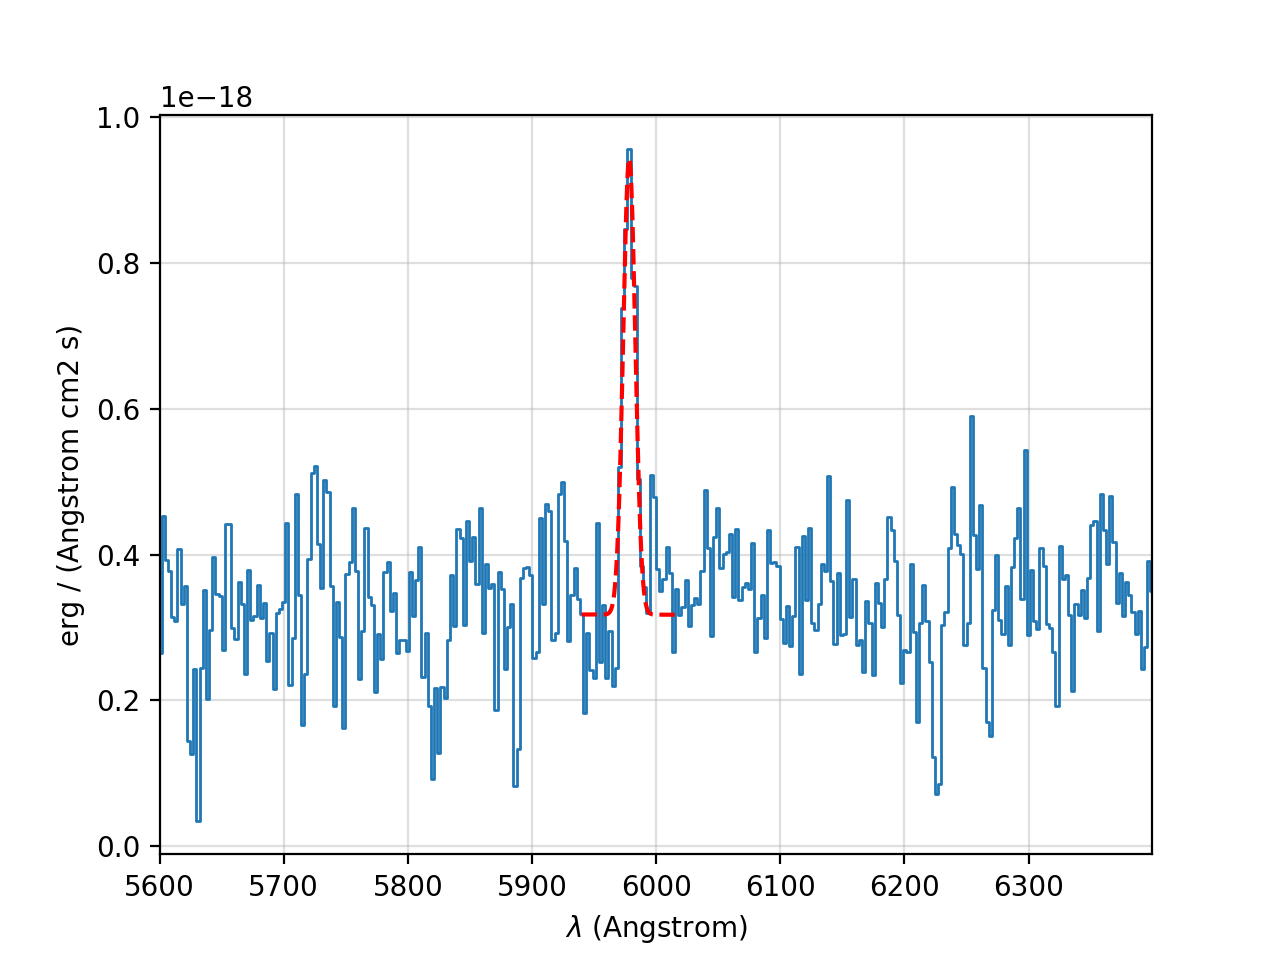

In [11]:
### Fit emission line with one Gaussian

%matplotlib notebook

subspec0.plot()  # First plot the spectrum

### Now fit the line using the gauss_fit function
### Manually inspect the spectrum for the wavelength range occupied by the line and calculate lmin and lmax.
### The wavelengths can be estimated by moving the cursor around on the plot above (or any active plot).
CII = subspec0.gauss_fit(lmin=5940, lmax=6020, unit=u.angstrom, plot=True) # plot=True plots the line on the spec

plt.grid(alpha=0.4)
plt.show()

In [15]:
### Print line parameters

CII.print_param()

### Derive parameters

# FWHM in velocity units
fwhm_v = CII.fwhm / CII.lpeak * 3e05
err_fwhm_v = CII.err_fwhm / CII.lpeak * 3e05

# Equivalent width using the continuum estimated by line fitting
# Use with caution! Almost always better to estimate the continuum separately for such calculations
ew = CII.flux / CII.cont

print("FWHM (km/s): ", "%.2f" %fwhm_v, "+/-", "%.2f" %err_fwhm_v, "km/s")
print("EW (A): ", "%.2f" %ew)


[INFO] Gaussian center = 5978.31 (error:0.494151)
[INFO] Gaussian integrated flux = 7.64156e-18 (error:6.70275e-19)
[INFO] Gaussian peak value = 6.25421e-19 (error:8.36723e-21)
[INFO] Gaussian fwhm = 11.4783 (error:1.16037)
[INFO] Gaussian continuum = 3.17753e-19


FWHM (km/s):  576.00 +/- 58.23 km/s
EW (A):  24.05


## Other line fitting tools
I have not implemented these on the example spectrum, but I am leaving them here just for illustration.

In [ ]:
### Fit emission line with two Gaussian

%matplotlib notebook

subspec0.plot()
Line1 = subspec0.gauss_fit(lmin=4020, lmax=4072, lpeak=4066, unit=u.angstrom, plot=True)
Line2 = subspec0.gauss_fit(lmin=4072, lmax=4120, lpeak=4081, unit=u.angstrom, plot=True)

plt.grid(alpha=0.4)
plt.show()

In [ ]:
### Fit emission line with asymmetric Gaussian

%matplotlib notebook

subspec0.plot()
Line_asym = subspec0.gauss_asymfit(lmin=5240, lmax=5350, unit=u.angstrom, plot=True)

plt.grid(alpha=0.4)
plt.show()

### Print line parameters
# Lyalpha_asym.print_param()

## Continuum estimation
The built in MPDAF function poly_spec performs a polynomial fit to estimate the continuum. By default, it rejects values above or below 3 sigma of the median while performing the fit. These can be changed by using the nsig variable in the function.

In the example below, I am fitting the continuum on the subspectrum. For effective EW calculation, estimating the continuum only in the subspectrum containing the emission line would be better than using the continuum estimate given by the Gaussian fit.

<IPython.core.display.Javascript object>


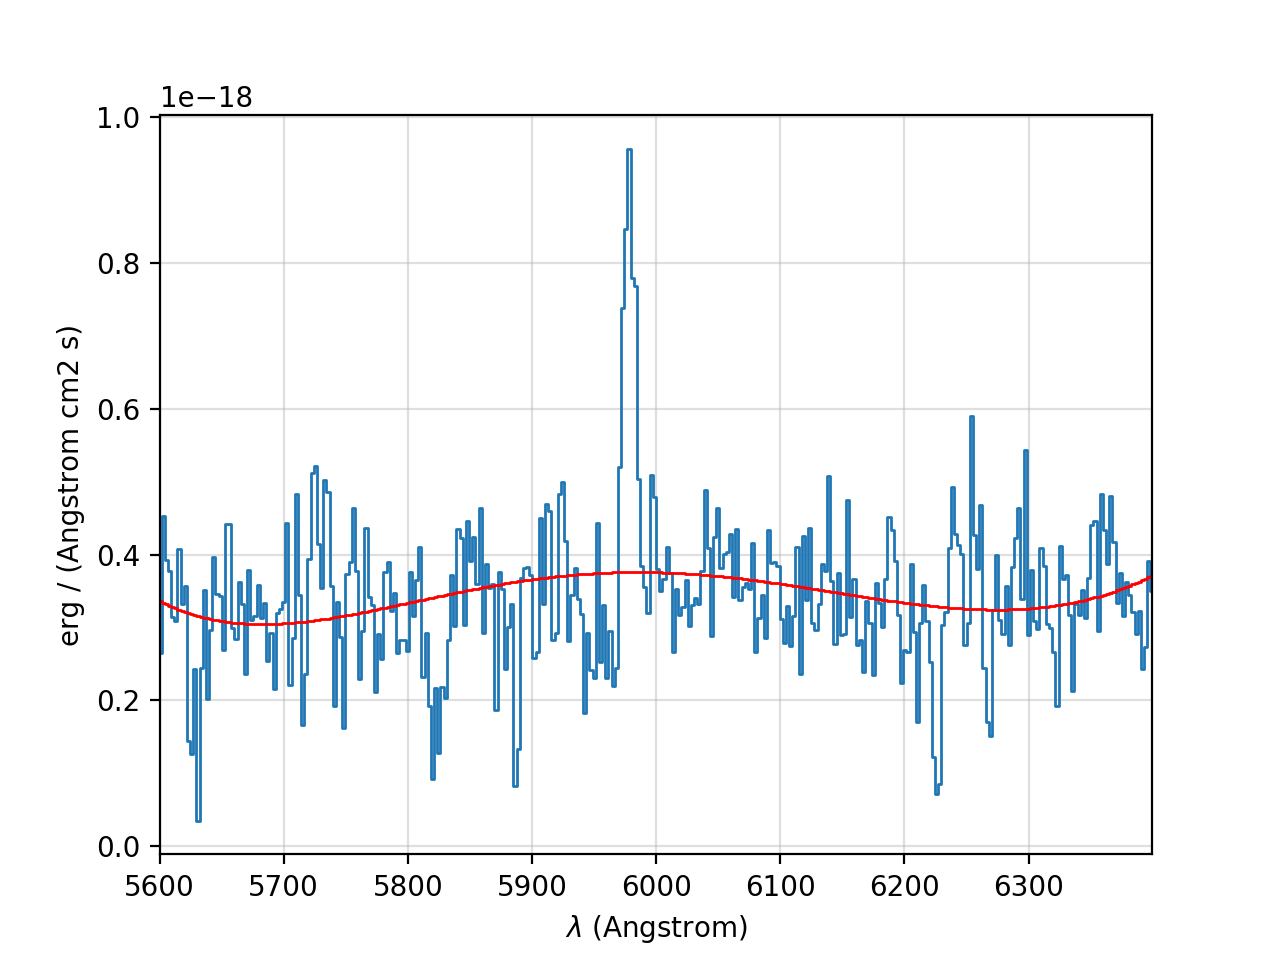

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [34]:
### Continuum estimation

%matplotlib notebook

# fig = plt.figure(figsize=(10,5))

# Estimate continuum for the entire spectrum
cont = subspec0.poly_spec(5) # degree of the polynomial

subspec0.plot() # plot the spectrum
cont.plot(color='r', lw=4) # show the continuum

### Plot limits
# plt.xlim(5200, 9400)
# plt.ylim(-0.5e-18, 0.2e-17)

plt.grid(alpha=0.4)
plt.show()

In [55]:
### Print the mean value of fitted continuum

print(cont.mean()[0])

3.426806632312343e-19


## Resampling the spectrum

Here is an example of resampling the spectrum in bins of wavelength

<IPython.core.display.Javascript object>


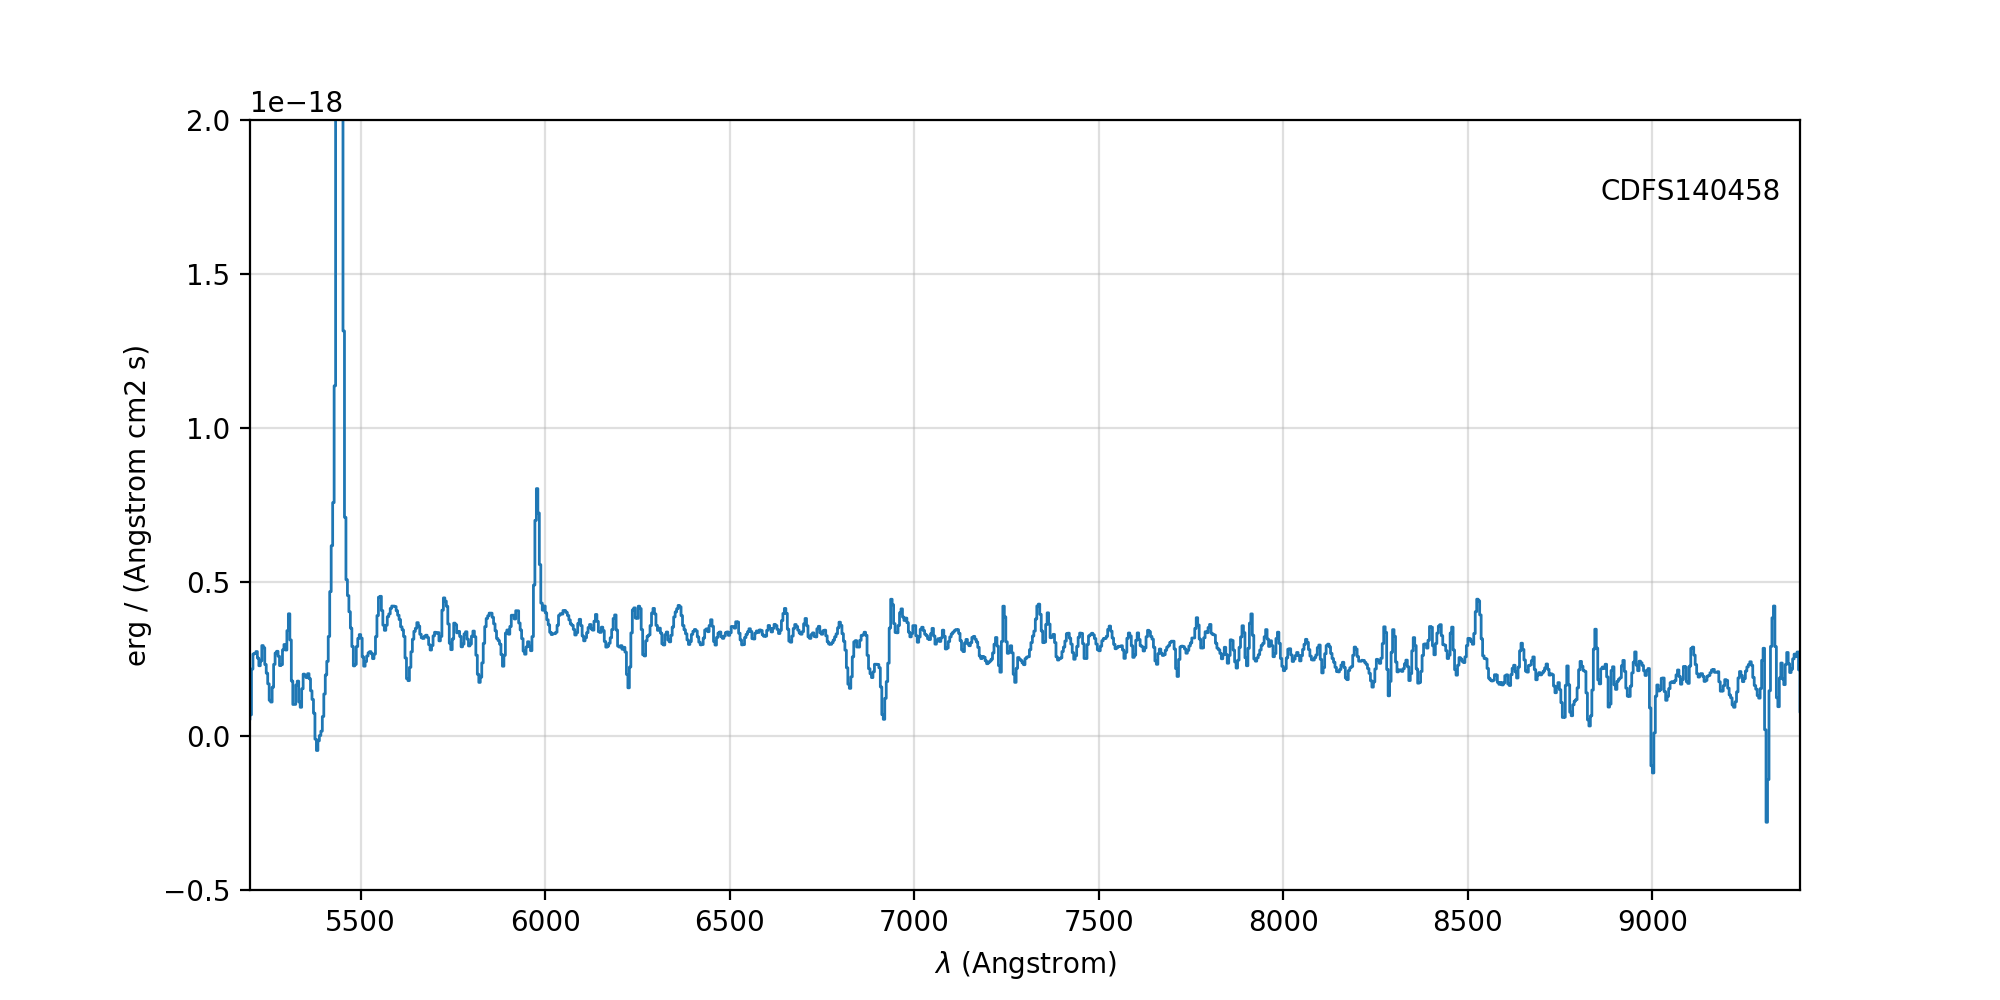

In [58]:
### Resample the original VANDELS spectrum

resamp_spec = spectrum0.resample(4, unit=u.Angstrom)

%matplotlib notebook

fig = plt.figure(figsize=(10,5))
resamp_spec.plot()

plt.figtext(0.8, 0.8, objid)

### Plot limits
plt.xlim(5200, 9400)
plt.ylim(-0.5e-18, 0.2e-17)

plt.grid(alpha=0.4)

plt.show()

## Repeat analysis on resampled spectrum

All the above mentioned examples can now also be performed on the resampled spectrum, which we named as 'resamp_spec'. Resampling can be particularly useful for faint line identification, stacking or other similar operations.